In [66]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

api = wandb.Api()

project_name = "BBI_reproduction"
group_names = [
    "goright_q_learning",
    "goright_expected_h2",
    "goright_expected_h5",
    "goright_sampling_h2",
    "goright_sampling_h5",
    "goright_perfect",
    "goright_bbi",
    "goright_bbi_linear",
    "goright_bbi_regression_tree",
    "goright_bbi_neural",
]

smoothing_window = 100 * 500

group_data = {}

for group_name in group_names:
    runs = api.runs(project_name, filters={"group": group_name})

    data = []

    for run in runs:
        history = run.history(
            keys=["evaluation/discounted_return"], pandas=True, samples=300_000
        )
        if not history.empty:
            history["run_name"] = run.name
            data.append(history)

    if data:  # Check if there is any data
        df = pd.concat(data, ignore_index=True)
        df.to_parquet(f"results_{group_name}.pqt", index=False)

        # Group by steps and compute mean and standard deviation across seeds
        grouped = (
            df.groupby("_step")
            .agg(
                avg_discounted_return=("evaluation/discounted_return", "mean"),
                std_discounted_return=("evaluation/discounted_return", "std"),
            )
            .reset_index()
        )

        # Apply smoothing over the aggregated results
        grouped["smoothed_avg"] = (
            grouped["avg_discounted_return"]
            .rolling(window=smoothing_window, min_periods=1)
            .mean()
        )

        grouped["smoothed_std_discounted_return"] = (
            grouped["std_discounted_return"]
            .rolling(window=smoothing_window, min_periods=1)
            .mean()
        )

        # Compute the standard error over both seeds and smoothing window
        grouped["smoothed_std_error"] = grouped[
            "smoothed_std_discounted_return"
        ] / np.sqrt(100)

        group_data[group_name] = grouped

In [79]:
import pandas as pd

group_data = {}

smoothing_window = 20 * 500

for group_name in group_names:
    df = pd.read_parquet(f"results_{group_name}.pqt")

    grouped = (
        df.groupby("_step")
        .agg(
            avg_discounted_return=("evaluation/discounted_return", "mean"),
            std_discounted_return=("evaluation/discounted_return", "std"),
        )
        .reset_index()
    )

    # Apply smoothing over the aggregated results
    grouped["smoothed_avg"] = (
        grouped["avg_discounted_return"]
        .rolling(window=smoothing_window, min_periods=1)
        .mean()
    )

    grouped["smoothed_std_discounted_return"] = (
        grouped["std_discounted_return"]
        .rolling(window=smoothing_window, min_periods=1)
        .mean()
    )

    # Compute the standard error over both seeds and smoothing window
    grouped["smoothed_std_error"] = grouped["smoothed_std_discounted_return"] / np.sqrt(
        100
    )

    group_data[group_name] = grouped

/var/folders/sd/s3_0xg3x0tlfrc5189jz9r100000gp/T/ipykernel_62112/197508610.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/lucruz/Documents/GitHub/research-sandbox/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


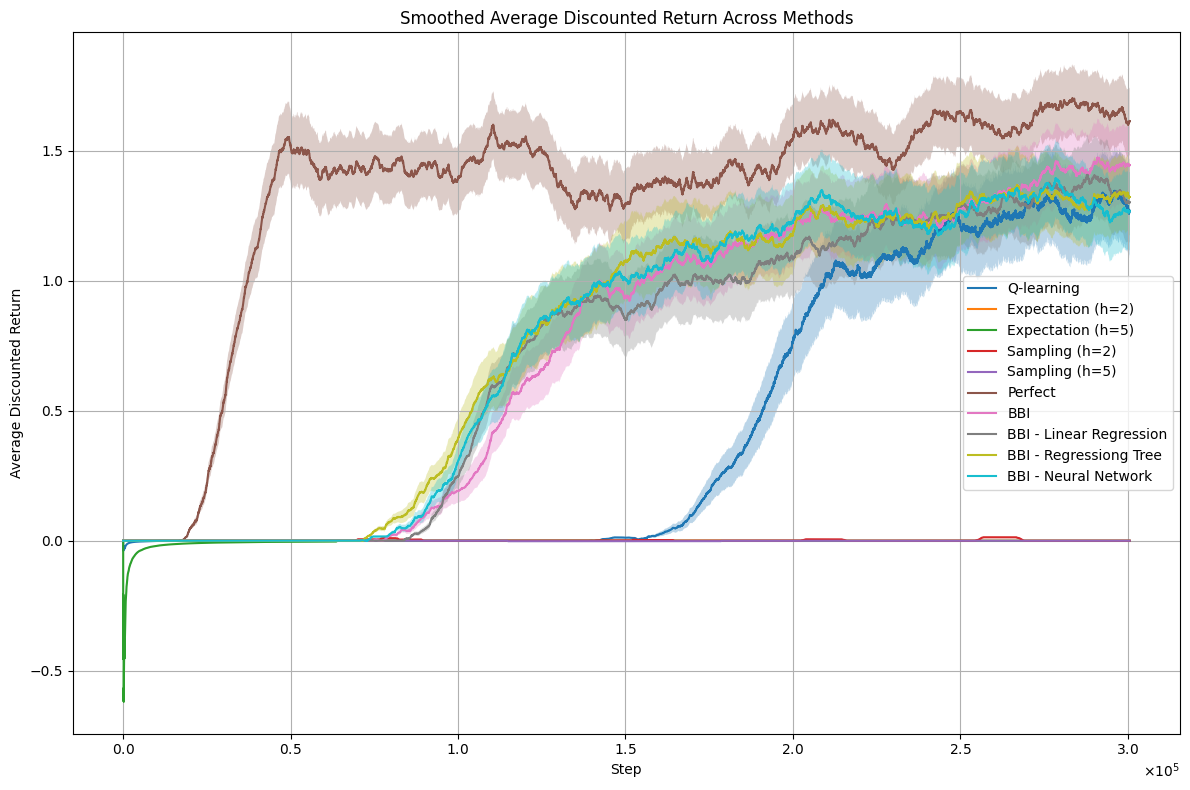

In [80]:
from matplotlib.ticker import ScalarFormatter

group_labels = [
    "Q-learning",
    "Expectation (h=2)",
    "Expectation (h=5)",
    "Sampling (h=2)",
    "Sampling (h=5)",
    "Perfect",
    "BBI",
    "BBI - Linear Regression",
    "BBI - Regressiong Tree",
    "BBI - Neural Network",
]

plt.figure(figsize=(12, 8))
for idx, grouped in enumerate(group_data.values()):
    plt.plot(grouped["_step"], grouped["smoothed_avg"], label=f"{group_labels[idx]}")
    plt.fill_between(
        grouped["_step"],
        grouped["smoothed_avg"] - grouped["smoothed_std_error"],
        grouped["smoothed_avg"] + grouped["smoothed_std_error"],
        alpha=0.3,
    )

# Adjust the x-axis
plt.xlabel("Step")
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis="x", style="sci", scilimits=(-3, 3))

# Other axis labels, title, and grid
plt.ylabel("Average Discounted Return")
plt.title("Smoothed Average Discounted Return Across Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()